# Melt Fe3Fe2

In this notebook we benchmark MagmaPandas Fe3Fe2 codes by reproducing calculations and/or figures from literature. When possible, we compare MagmaPandas results to results from codes or data provided with the original publication of the model. Unfortunately, in many cases these are not available, in which case we've compiled the input data ourselves. In these cases, we cannot be 100% sure that we use exacly the same input data and small differences between MagmaPandas results and data in published figures are expected.

In [1]:
import MagmaPandas as mp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import geoplot as gp
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar
import elementMass as e

from MagmaPandas.Fe_redox.Fe3Fe2_models import *
from MagmaPandas.model_calibrations import get_calibration_data
from MagmaPandas.fO2 import IW

mm = 1 / 25.4

### Armstrong et al. 2019

For the model from {cite:t}`Armstrong2019` we reproduce their Fig. 1 from the main text. Input data are according the their Supplementary text.

In [2]:
# andesite composition from supplementary table S1, with Fe2O3(total) converted to FeO(total)
andesite = mp.MagmaSeries(
    {
        "SiO2": 57.3,
        "TiO2": 3.0,
        "Al2O3": 14.8,
        "FeO": 8.46,
        "MgO": 2.1,
        "CaO": 7.4,
        "Na2O": 4.4,
        "K2O": 1.1,
    }, units="wt. %", datatype="oxide"
)

# temperatures and pressures from Fig. 1
temperatures_armstrong = np.array([1673, 1773, 1873, 2023, 2373, 2473])
pressures_armstrong = np.linspace(1, 25e4, 100)

In [3]:
# fO2 at Ru-RuO2 according to equation S3 from Armstrong et al. (2019)
from MagmaPandas.fO2.RuRuO2 import fO2_RuRuO2

fO2_armstrong = pd.DataFrame(index=pressures_armstrong)
Fe3Fe2_armstrong = pd.DataFrame(index=pressures_armstrong)

for T in temperatures_armstrong:
    fO2_armstrong.loc[pressures_armstrong, T] = fO2_RuRuO2(T_K=T, P_bar=pressures_armstrong, logshift=0)
    Fe3Fe2_armstrong.loc[pressures_armstrong, T] = armstrong2019.calculate_Fe3Fe2(
        andesite.moles(), T_K=T, P_bar=pressures_armstrong, fO2=fO2_armstrong[T].values
    ).values

Fe3Fe_total_armstrong = Fe3Fe2_armstrong.map(lambda x: x / (x+1))


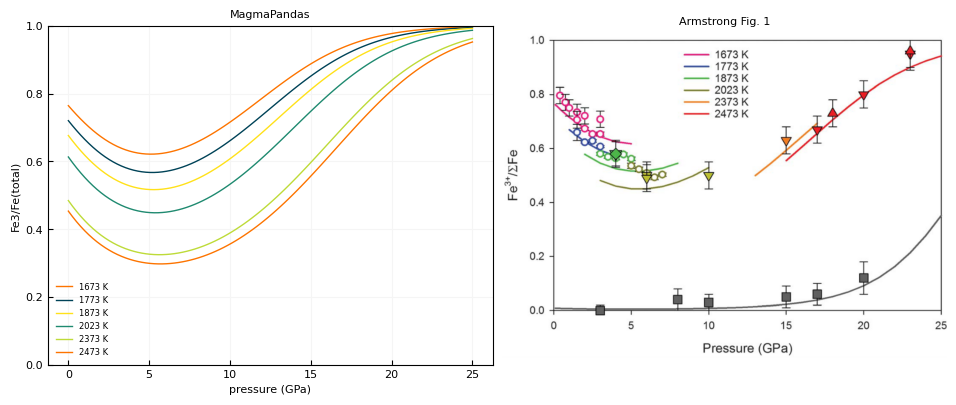

In [4]:
gp.layout(colors=gp.colors.vitaminC)

fig, axs = plt.subplots(1, 2, figsize=(240*mm, 100*mm))

for T in temperatures_armstrong:
    axs[0].plot(pressures_armstrong / 1e4, Fe3Fe_total_armstrong[T], "-", label=f"{T:d} K")

img = mpimg.imread("./data/Fe3Fe2/Fe3Fe2_Armstrong2019_Fig1.png")
axs[1].imshow(img)
axs[1].axis("off")

axs[0].legend()
axs[0].set_ylim(0,1)

axs[0].set_title("MagmaPandas")
axs[1].set_title("Armstrong Fig. 1")

axs[0].set_xlabel("pressure (GPa)")
axs[0].set_ylabel("Fe3/Fe(total)")


plt.show()

### Borisov et al. 2018

For the {cite:t}`borisov_ferricferrous_2018` model we calculate Fe3Fe2 for their calibration dataset in order to reproduce the upper left panel of their Fig. 6. We use the experimental data provided in their electronic supplement.

In [5]:
borisov_calibration = pd.read_csv("./data/Fe3Fe2/Fe3Fe2_borisov2018.csv")
borisov_datasets = ["b2013", "b2015", "b2017", "b2018"]
borisov_data = borisov_calibration.query("ref in @borisov_datasets")
other_data = borisov_calibration.query("ref not in @borisov_datasets")

In [6]:
T_K_borisov = borisov_data["T_K"]
fO2_borisov = borisov_data["fO2"]
Fe3Fe2_experiment_borisov = borisov_data["Fe3Fe2"]
borisov_compositions = borisov_data.iloc[:, 6:15]

T_K_other = other_data["T_K"]
fO2_other = other_data["fO2"]
Fe3Fe2_experiment_other = other_data["Fe3Fe2"]
other_compositions = other_data.iloc[:, 6:15]

In [7]:
Fe3Fe2_armstrong = borisov2018.calculate_Fe3Fe2(melt_mol_fractions=borisov_compositions, T_K=T_K_borisov, fO2=fO2_borisov)
Fe3Fe2_previous = borisov2018.calculate_Fe3Fe2(melt_mol_fractions=other_compositions, T_K=T_K_other, fO2=fO2_other)

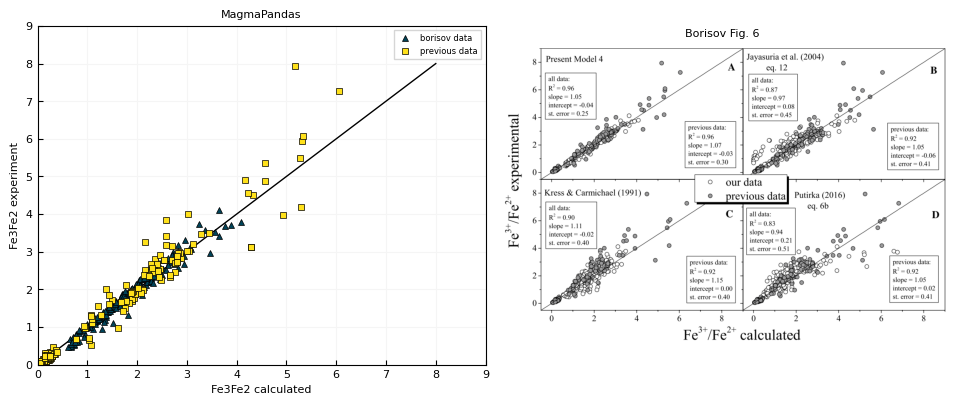

In [8]:
gp.layout(colors=gp.colors.vitaminC)

fig, axs = plt.subplots(1, 2, figsize=(240*mm, 100*mm))

axs[0].plot([0, 8], [0, 8], "-", color="k")
axs[0].plot(Fe3Fe2_armstrong, Fe3Fe2_experiment_borisov, lw=0., label="borisov data")
axs[0].plot(Fe3Fe2_previous, Fe3Fe2_experiment_other, lw=0., label="previous data")

img = mpimg.imread("./data/Fe3Fe2/Fe3Fe2_borisov2018_fig6.png")
axs[1].imshow(img)
axs[1].axis("off")

axs[0].set_xlim(0, 9)
axs[0].set_ylim(0, 9)
axs[0].legend(frameon=True, fancybox=False)

axs[0].set_title("MagmaPandas")
axs[1].set_title("Borisov Fig. 6")

axs[0].set_ylabel("Fe3Fe2 experiment")
axs[0].set_xlabel("Fe3Fe2 calculated")


plt.show()

### Deng et al. 2020

For the {cite:t}`Deng2020` model, we are going to reproduce Fig. 3b, with the data and code provided by Deng on his [github page](https://github.com/neojie/oxidation_lite).

In [9]:
geotherm_file = "./data/Fe3Fe2/Fe3Fe2_deng2020/geotherm.csv"
compositions_file = "./data/Fe3Fe2/Fe3Fe2_deng2020/compositions_cation_molfractions.csv"
fO2_file = "./data/Fe3Fe2/Fe3Fe2_deng2020/log10fO2.csv"

earth_file = "./data/Fe3Fe2/Fe3Fe2_deng2020/earth.csv"
moon_file = "./data/Fe3Fe2/Fe3Fe2_deng2020/moon.csv"
mars_file = "./data/Fe3Fe2/Fe3Fe2_deng2020/mars.csv"

In [10]:
compositions_deng = mp.Melt(pd.read_csv(compositions_file, index_col=[0]), units="mol fraction", datatype="cation")
earth_deng = pd.read_csv(earth_file)
moon_deng = pd.read_csv(moon_file)
mars_deng = pd.read_csv(mars_file)

earth_composition_deng = compositions_deng.oxides().loc["earth"].recalculate()
moon_composition_deng = compositions_deng.oxides().loc["moon"].recalculate()
mars_composition_deng = compositions_deng.oxides().loc["mars"].recalculate()

In [11]:
Fe3Fe2_earth_calculated_deng = deng2020.calculate_Fe3Fe2(
    melt_mol_fractions=earth_composition_deng,
    T_K=earth_deng["T_K"],
    P_bar=earth_deng["P_GPa"] * 1e4,
    fO2=10 ** earth_deng["log10fO2"],
)

Fe3Fe2_moon_calculated_deng = deng2020.calculate_Fe3Fe2(
    melt_mol_fractions=moon_composition_deng,
    T_K=moon_deng["T_K"],
    P_bar=moon_deng["P_GPa"] * 1e4,
    fO2=10 ** moon_deng["log10fO2"],
)

Fe3Fe2_mars_calculated_deng = deng2020.calculate_Fe3Fe2(
    melt_mol_fractions=mars_composition_deng,
    T_K=mars_deng["T_K"],
    P_bar=mars_deng["P_GPa"] * 1e4,
    fO2=10 ** mars_deng["log10fO2"],
    melt_Fe="25molpc"
)

In [12]:
Fe3Fetotal_earth_calculated_deng  = Fe3Fe2_earth_calculated_deng / (1+ Fe3Fe2_earth_calculated_deng)
Fe3Fetotal_moon_calculated_deng  = Fe3Fe2_moon_calculated_deng / (1+ Fe3Fe2_moon_calculated_deng)
Fe3Fetotal_mars_calculated_deng  = Fe3Fe2_mars_calculated_deng / (1+ Fe3Fe2_mars_calculated_deng)

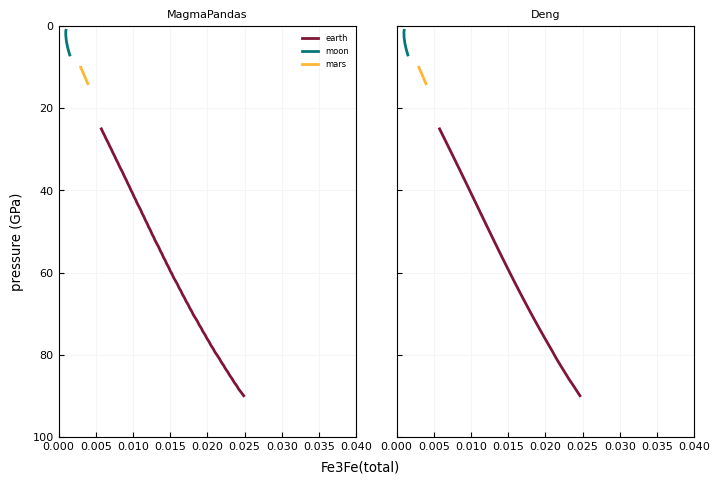

In [13]:
mm = 1/25.4
lw=2

gp.layout(colors=gp.colors.bella)

fig, axs = plt.subplots(1, 2, figsize=(180*mm, 120*mm), sharex=True, sharey=True)

axs[1].plot(earth_deng["Fe3Fetotal"], earth_deng["P_GPa"], "-", lw=lw, label="earth")
axs[0].plot(Fe3Fetotal_earth_calculated_deng, earth_deng["P_GPa"], "-", lw=lw, label="earth")

axs[1].plot(moon_deng["Fe3Fetotal"], moon_deng["P_GPa"], "-", lw=lw, label="moon")
axs[0].plot(Fe3Fetotal_moon_calculated_deng, moon_deng["P_GPa"], "-", lw=lw ,label="moon")

axs[1].plot(mars_deng["Fe3Fetotal"], mars_deng["P_GPa"], "-", lw=lw, label="mars")
axs[0].plot(Fe3Fetotal_mars_calculated_deng, mars_deng["P_GPa"], "-", lw=lw, label="mars")

axs[0].legend()

axs[0].set_title("MagmaPandas")
axs[1].set_title("Deng")

axs[0].set_xlim(0, 0.04)
axs[0].set_ylim(0, 100)
axs[0].invert_yaxis()

fig.supxlabel("Fe3Fe(total)")
fig.supylabel("pressure (GPa)")

plt.show()

### Hirschmann (2022)

This model uses eq. 21 from {cite:t}`Hirschmann2022`. Here we reproduce results from calculations with the matlab scripts provided as electronic supplement to the paper. As input we use the example data that came with the supplement.

In [14]:
hirschmann_file = "./data/Fe3Fe2/Fe3Fe2_hirschmann.csv"

In [15]:
hirschmann = pd.read_csv(hirschmann_file).sort_values("P_GPa")
T_K_hirschmann = hirschmann["T_K"]
P_bar_hirschmann = hirschmann["P_GPa"] * 1e4
fO2_hirschmann = 10 ** hirschmann["log10fO2"]

In [16]:
compositions_hirschmann = mp.Melt(hirschmann.iloc[:, 8:], units="wt. %", datatype="oxide")

In [17]:
Fe3Fe2_hirschmann_armstrong = hirschmann2022.calculate_Fe3Fe2(
    melt_mol_fractions=compositions_hirschmann.moles(),
    T_K=T_K_hirschmann,
    P_bar=P_bar_hirschmann,
    fO2=fO2_hirschmann,
    dVdP_method="armstrong2019",
)

Fe3Fe2_hirschmann_deng = hirschmann2022.calculate_Fe3Fe2(
    melt_mol_fractions=compositions_hirschmann.moles(),
    T_K=T_K_hirschmann,
    P_bar=P_bar_hirschmann,
    fO2=fO2_hirschmann,
    dVdP_method="deng2020",
)

In [18]:
Fe3Fetotal_hirschmann_armstrong = Fe3Fe2_hirschmann_armstrong / (1+Fe3Fe2_hirschmann_armstrong)
Fe3Fetotal_hirschmann_deng = Fe3Fe2_hirschmann_deng / (1+Fe3Fe2_hirschmann_deng)

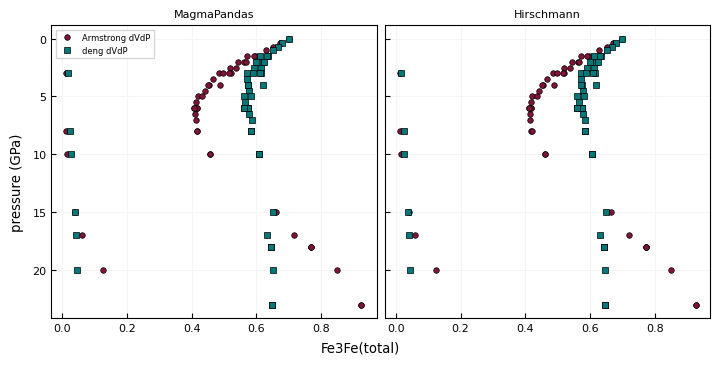

In [19]:
mm = 1/25.4
lw=2

gp.layout(colors=gp.colors.bella)

fig, axs = plt.subplots(1, 2, figsize=(180*mm, 90*mm), sharex=True, sharey=True)

axs[1].plot(hirschmann["Fe3Fetotal_armstrong"], P_bar_hirschmann / 1e4, "o", lw=lw, label="Armstrong dVdP")
axs[0].plot(Fe3Fetotal_hirschmann_armstrong, P_bar_hirschmann / 1e4, "o", lw=lw, label="Armstrong dVdP")

axs[1].plot(hirschmann["Fe3Fetotal_deng"], P_bar_hirschmann / 1e4, "s", lw=lw, label="deng dVdP")
axs[0].plot(Fe3Fetotal_hirschmann_deng, P_bar_hirschmann / 1e4, "s", lw=lw, label="deng dVdP")

axs[0].legend(frameon=True, fancybox=False)

axs[0].set_title("MagmaPandas")
axs[1].set_title("Hirschmann")


axs[0].invert_yaxis()

fig.supxlabel("Fe3Fe(total)")
fig.supylabel("pressure (GPa)")

plt.show()

### Jayasuriya et al (2004)

Here we reproduce figure 10a from {cite:t}`Jayasuriya2004` with data compiled from literature

In [20]:
jayasuriya_calibration = get_calibration_data(parameter="Fe3Fe2", model="jayasuriya2004")
jayasuriya_calibration = jayasuriya_calibration.query("ref != 'J2004'")

jayasuriya_calibration = jayasuriya_calibration.set_index(["ref", "run"], drop=True)

In [21]:
idx = pd.IndexSlice
remove_samples = idx[["T1980", "S1980"], ["123", "14"]]
remove_samples = jayasuriya_calibration.loc[remove_samples, :].index

jayasuriya_calibration = jayasuriya_calibration.drop(remove_samples, axis=0)

In [22]:
T_K_jayasuriya = jayasuriya_calibration["T_K"].reset_index(drop=True)
P_bar_jayasuriya = jayasuriya_calibration["P_bar"].reset_index(drop=True)
fO2_jayasuriya = jayasuriya_calibration["fO2"].reset_index(drop=True)

Fe3Fe2_measured_jayasuriya = jayasuriya_calibration["_Fe3Fe2"].reset_index(drop=True)

compositions_jayasuriya = mp.Melt(
    jayasuriya_calibration.iloc[:, :13].reset_index(drop=True),
    units="wt. %",
    datatype="oxide",
)

In [23]:
Fe3Fe2_calculated_jayasuriya = jayasuriya2004.calculate_Fe3Fe2(
    melt_mol_fractions=compositions_jayasuriya.moles(),
    T_K=T_K_jayasuriya,
    P_bar=P_bar_jayasuriya,
    fO2=fO2_jayasuriya,
)

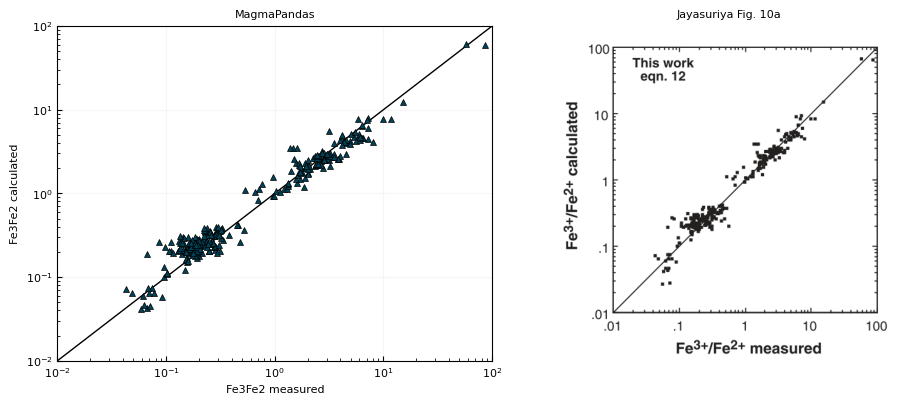

In [24]:
gp.layout(colors=gp.colors.vitaminC)

limits = (0.01, 100)

fig, axs = plt.subplots(1, 2, figsize=(240*mm, 100*mm))

axs[0].plot(limits, limits, "-", color="k")
axs[0].plot(Fe3Fe2_measured_jayasuriya, Fe3Fe2_calculated_jayasuriya, lw=0.)


img = mpimg.imread("./data/Fe3Fe2/Fe3Fe2_jayasuriya2004_fig10a.png")
axs[1].imshow(img)
axs[1].axis("off")

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlim(*limits)
axs[0].set_ylim(*limits)


axs[0].set_title("MagmaPandas")
axs[1].set_title("Jayasuriya Fig. 10a")

axs[0].set_xlabel("Fe3Fe2 measured")
axs[0].set_ylabel("Fe3Fe2 calculated")


plt.show()

Note that there are minor differences in results. This is becase the orginal manuscript did not provide the plotted dataset. We compiled the dataset ourselves from literature, but apparently there are some small differences between the two datasets.

### Kress & Carmichael (1991)

This model uses equation 7 from {cite:t}`kress_compressibility_1991`. However, the paper does not contain any figures that use this model, or show the calibration. Instead of a benchmark we provide a plot of measured vs. calculated Fe3Fe2 in the calibration dataset. Note that the model is a straightforward linear equation and leaves little room for error.

Get the calibration data from the publications listed on p.87 in the paper.

In [25]:
calibration_KC1991 = get_calibration_data(parameter="Fe3Fe2", model="kress_carmichael1991")

Remove the CAFS and NAFS samples

In [26]:
keep_samples = (calibration_KC1991["MgO"] > 0.0)
calibration_KC1991 = calibration_KC1991.loc[keep_samples].copy()
len(calibration_KC1991)

268

Note that the paper mentions that they used 228 experiments in their calibration, while we have 268. Apparently the authors have not used all experiments from the puplications they listed.

In [27]:
T_K_KC1991 = calibration_KC1991["T_K"]
P_bar_KC1991 = calibration_KC1991["P_bar"]
fO2_KC1991 = calibration_KC1991["fO2"]

compositions_KC1991 = mp.Melt(calibration_KC1991.iloc[:, 2:15], units="wt. %", datatype="oxide")

In [28]:
Fe3Fe2_calculated_KC1991 = kress_carmichael1991.calculate_Fe3Fe2(
    melt_mol_fractions=compositions_KC1991.moles(),
    T_K=T_K_KC1991,
    P_bar=P_bar_KC1991,
    fO2=fO2_KC1991,
)

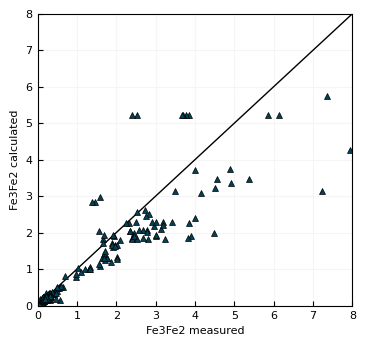

In [29]:
gp.layout(colors=gp.colors.vitaminC)

limits = (0.0, 8)

fig, ax = plt.subplots(figsize=(90*mm, 85*mm))

ax.plot(limits, limits, "-", color="k")
ax.plot(calibration_KC1991["_Fe3Fe2"], Fe3Fe2_calculated_KC1991, lw=0.)
ax.set_xlim(*limits)
ax.set_ylim(*limits)


ax.set_xlabel("Fe3Fe2 measured")
ax.set_ylabel("Fe3Fe2 calculated")


plt.show()

We see that the model works reasonably well at Fe3/Fe2 ratios < 1, but becomes inaccurate at more oxidized ratios.

### O'Neill et al. (2006)

This model uses equation 10 from {cite:t}`ONeill2006`. To validate our code, we reproduce fig. 8.

In [30]:
MORB_oneill = mp.MagmaSeries(
    {
        "SiO2": 46.3,
        "TiO2": 1.2,
        "Al2O3": 18.6,
        "FeO": 9.6,
        "MgO": 10.0,
        "CaO": 11.8,
        "Na2O": 2.3,
        "K2O": 0.1,
        "P2O5": 0.1,
    },
    units="wt. %",
    datatype="oxide",
)

In [31]:
Fe3Fe_total = 0.12
Fe3Fe2 = Fe3Fe_total / (1 - Fe3Fe_total)

fO2_solver = (
    lambda fO2_guess, P_bar: oneill2006.calculate_Fe3Fe2(
        melt_mol_fractions=MORB_oneill.moles(),
        P_bar=P_bar,
        T_K=1673,
        fO2=fO2_guess,
    )
    - Fe3Fe2
)

In [32]:
pressures = np.linspace(1, 3e4, 100)
fO2 = pd.Series(index=pressures)

for P in pressures:
    fO2[P] = root_scalar(fO2_solver, bracket=[10**-8, 1], args=(P)).root

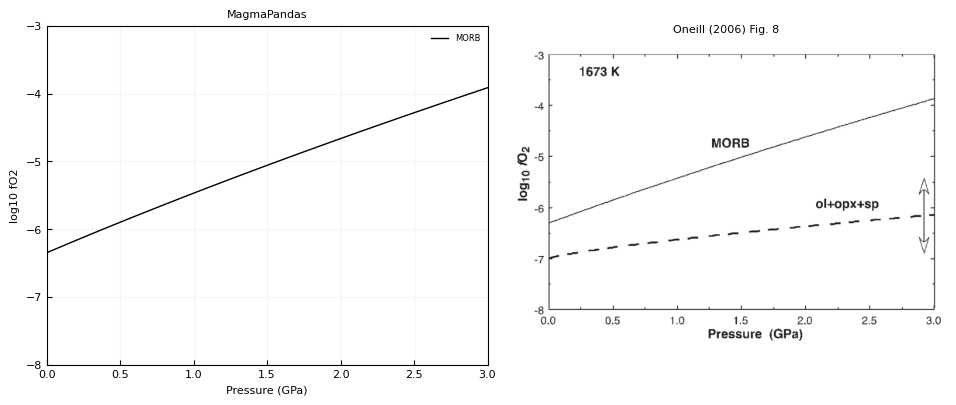

In [33]:
gp.layout(colors=gp.colors.vitaminC)


fig, axs = plt.subplots(1, 2, figsize=(240*mm, 100*mm))


axs[0].plot(pressures / 1e4, np.log10(fO2), "-", color="k", label="MORB")

axs[0].set_xlim(0, 3)

img = mpimg.imread("./data/Fe3Fe2/Fe3Fe2_oneill2006_fig8.png")
axs[1].imshow(img)
axs[1].axis("off")
axs[0].set_ylim(-8, -3)
axs[0].legend()

axs[0].set_title("MagmaPandas")
axs[1].set_title("Oneill (2006) Fig. 8")

axs[0].set_xlabel("Pressure (GPa)")
axs[0].set_ylabel("log10 fO2")


plt.show()

### O'neill et al. (2018)

This model implements equation 9a from {cite:t}`oneill_oxidation_2018`. To validate our code we reproduce fig. 6 from the original paper.

In [34]:
calibration_oneill2018 = get_calibration_data(parameter="Fe3Fe2", model="oneill2018")
calibration_oneill2018 = calibration_oneill2018.query("SiO2 < 59.9")

In [35]:
datasets = {
    "redox series": ["J2004", "C2009", "Be2018", "R2013"],
    "berkeley": ["S1980", "K1983", "KC1988", "KC1991"],
    "borisov": ["B2013", "B2015"],
    "moore": ["M1995"],
    "thornber": ["T1980"],
    "fudali": ["F1965"],
    "partzsch": ["P2004"],
}

According to the caption of Table 2, we subtract 0.062 from Fe3/Fe(total) by Fudali (1965) and Thornber et al. (1980), 0.55 from the values reported by Partzsch et al. 2004 and 0.055 added to those of Moore et al. (1995).

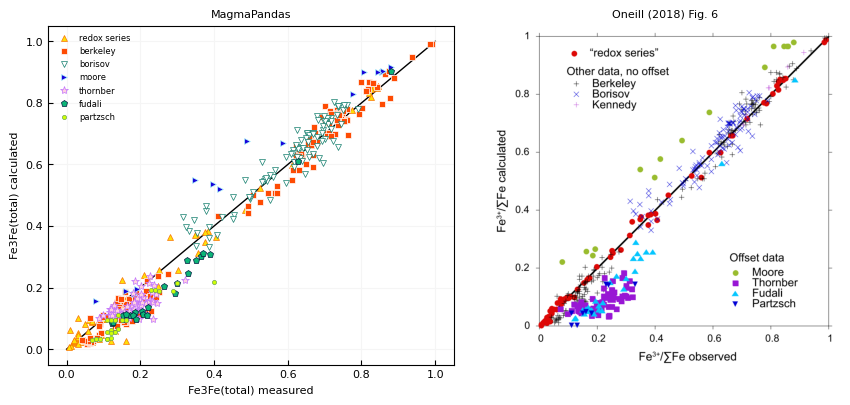

In [36]:
gp.layout(colors=gp.colors.bright)


fig, axs = plt.subplots(1, 2, figsize=(220 * mm, 100 * mm))

axs[0].plot((0,1), (0,1), "-", color="k")
for label, dataset in datasets.items():
    data = calibration_oneill2018.query("ref in @dataset")
    compositions = mp.Melt(data.iloc[:, 2:15], units="wt. %", datatype="oxide")

    Fe3Fe2 = oneill2018.calculate_Fe3Fe2(
        melt_mol_fractions=compositions.moles(),
        T_K=data["T_K"],
        P_bar=data["P_bar"],
        fO2=data["fO2"],
    )

    Fe3Fetotal_calculated = Fe3Fe2 / (1+Fe3Fe2)
    Fe3Fetotal_measured = data["_Fe3Fe2"] / (1+data["_Fe3Fe2"])
    if label in ("F1965", "T1980"):
        Fe3Fetotal_measured -= 6.3e-2
    elif label == ("P2004"):
        Fe3Fetotal_measured -= 5.5e-2
    elif label == ("M1995"):
        Fe3Fetotal_measured += 5.5e-2

    axs[0].plot(Fe3Fetotal_measured, Fe3Fetotal_calculated, lw=0., label=label)


img = mpimg.imread("./data/Fe3Fe2/Fe3Fe2_oneill2018_fig6.png")
axs[1].imshow(img)
axs[1].axis("off")

axs[0].legend()

axs[0].set_title("MagmaPandas")
axs[1].set_title("Oneill (2018) Fig. 6")

axs[0].set_xlabel("Fe3Fe(total) measured")
axs[0].set_ylabel("Fe3Fe(total) calculated")


plt.show()

Results are very similar to the O'Neill plot. The input data was not provided and had to be compiled from literature. Small diferences with the publised figure are most likelely due to small differences in input data.

### Putirka (2016) eqs. 6b and 6c

#### eq. 6b

This model uses equation 6b from {cite:t}`Putirka2016`. To validate our code with reprodce figure 4g and h. Note that we do not use the data from Schmidt & Behrens (2008) because they do not provide good constraints on fO2, or Fe3Fe2 ratios in the experimental products.

In [37]:
calibration_putirka2016_6b = get_calibration_data(parameter="Fe3Fe2", model="putirka2016_6b")
calibration_putirka2016_6c = get_calibration_data(parameter="Fe3Fe2", model="putirka2016_6c")

calibration_putirka2016 = pd.concat([calibration_putirka2016_6b, calibration_putirka2016_6c], axis=0)



In [38]:
datasets = {
    "DS1": ["G2001", "K1983", "KC1988", "M1995", "S1980"],
    "DS2": ["P2004", "S2008"],
    "DS3": ["Bc2005"],
}

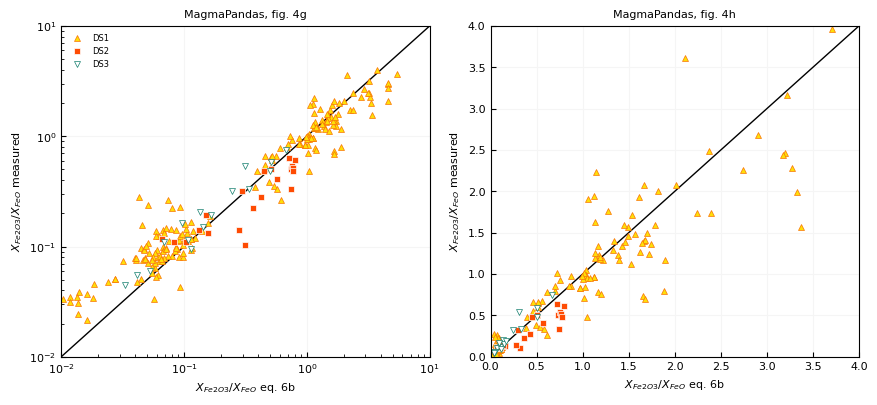

In [39]:
gp.layout(colors=gp.colors.bright)


fig, axs = plt.subplots(1, 2, figsize=(220 * mm, 100 * mm))

limits = (0.01, 10)

axs[0].plot(limits, limits, "-", color="k")
axs[1].plot(limits, limits, "-", color="k")
for label, dataset in datasets.items():
    data = calibration_putirka2016.query("ref in @dataset")
    compositions = mp.Melt(data.iloc[:, 2:15], units="wt. %", datatype="oxide")

    Fe3Fe2 = oneill2018.calculate_Fe3Fe2(
        melt_mol_fractions=compositions.moles(),
        T_K=data["T_K"],
        P_bar=data["P_bar"],
        fO2=data["fO2"],
    )

    XFe2O3_XFeO = Fe3Fe2 / 2
    XFe2O3_XFeO_measured = data["_Fe3Fe2"] / 2    

    axs[0].plot(XFe2O3_XFeO, XFe2O3_XFeO_measured, lw=0., label=label)
    axs[1].plot(XFe2O3_XFeO, XFe2O3_XFeO_measured, lw=0., label=label)

axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlim(*limits)
axs[0].set_ylim(*limits)
axs[0].legend()

axs[1].set_xlim(0,4)
axs[1].set_ylim(0,4)

axs[0].set_title("MagmaPandas, fig. 4g")
axs[1].set_title("MagmaPandas, fig. 4h")

for ax in axs[:2]:
    ax.set_xlabel("$X_{Fe2O3}/X_{FeO}$ eq. 6b")
    ax.set_ylabel("$X_{Fe2O3}/X_{FeO}$ measured")


plt.show()

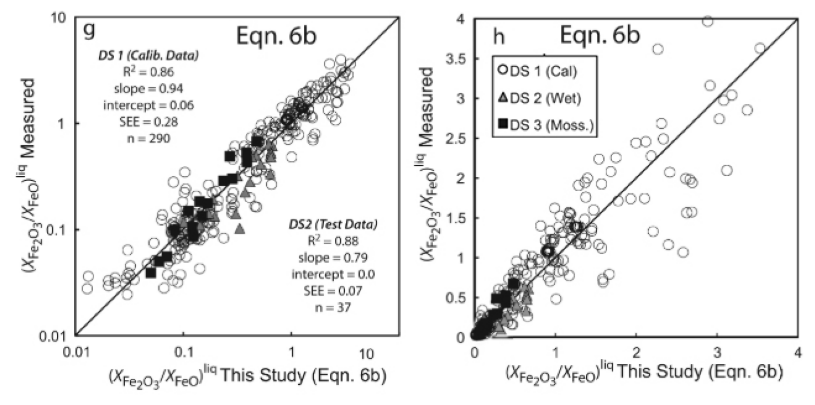

In [40]:
fig, ax = plt.subplots(figsize=(220 * mm, 100 * mm))

img = mpimg.imread("./data/Fe3Fe2/Fe3Fe2_putirka2016_fig4gh.jpg")
ax.imshow(img)
ax.axis("off")

plt.show()

Results are very similar to Putirka plots. The input data was not provided and had to be compiled from literature. Differences with the publised figure are most likelely due to small differences in input data.

#### eq. 6c

For equation 6c, Putirka doesn't provide any results. Here we show predicted vs. measured Fe3Fe2 in the calibration dataset (Botcharnikov et al., 2005)

In [41]:
compositions = mp.Melt(calibration_putirka2016_6c.iloc[:, 2:15], units="wt. %", datatype="oxide")

Fe3Fe2_putirka6c = oneill2018.calculate_Fe3Fe2(
    melt_mol_fractions=compositions.moles(),
    T_K=calibration_putirka2016_6c["T_K"],
    P_bar=calibration_putirka2016_6c["P_bar"],
    fO2=calibration_putirka2016_6c["fO2"],
)

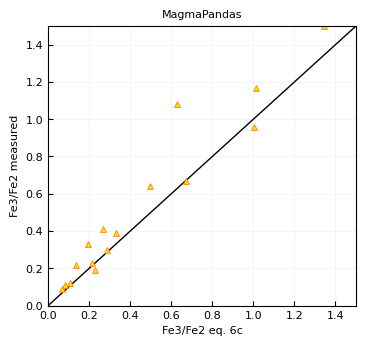

In [42]:
gp.layout(colors=gp.colors.bright)

fig, ax = plt.subplots(figsize=(90 * mm, 85 * mm))

limits = (0.0, 1.5)

ax.plot(limits, limits, "-", color="k")
ax.plot(Fe3Fe2_putirka6c, calibration_putirka2016_6c["_Fe3Fe2"], lw=0.0)

ax.set_xlim(*limits)
ax.set_ylim(*limits)


ax.set_title("MagmaPandas")


ax.set_xlabel("Fe3/Fe2 eq. 6c")
ax.set_ylabel("Fe3/Fe2 measured")


plt.show()

The model seems to underestimate some in general. However, this is potentially caused by small differences between our compiled dataset and the dataset used by Putirka. Additionally, element masses used in the calculations may be slightly different in our model and the Putirka calculations. The calibration dataset was not published, and example calculations are not available, so unfortunately there is no way to confirm these inconsistencies.

### Sun et al. (2024)

This model uses equation 9 from {cite:t}`Sun2024`. To validate our code we compare our results to those from the excelsheet provide by Sun et al. (2024). In this excelsheet, dV is calculated according to the parameterization from table S3. Results calculated with dV from Deng et al. (2020) are somewhat different. As input data we use the 1 bar experiments from Borisov et al. (2013) and the high-pressure experiments from Armstrong et al. (2019, 3 - 23 GPa).

In [43]:
sun2024_inputfile = "./data/Fe3Fe2/Fe3Fe2_input_sun2024.csv"
sun2024_input = pd.read_csv(sun2024_inputfile)

In [44]:
compositions = mp.Melt(sun2024_input.iloc[:, 2:15], units="wt. %", datatype="oxide")

sun2024_input["Fe3Fe2_magmapandas"] = sun2024.calculate_Fe3Fe2(
    melt_mol_fractions=compositions.moles(),
    T_K=sun2024_input["T_K"],
    P_bar=sun2024_input["P_bar"],
    fO2=sun2024_input["fO2"],
    dV="parameterised"
)



In [45]:
sun2024_input["Fe3Fe2_magmapandas_deng"] = sun2024.calculate_Fe3Fe2(
    melt_mol_fractions=compositions.moles(),
    T_K=sun2024_input["T_K"],
    P_bar=sun2024_input["P_bar"],
    fO2=sun2024_input["fO2"],
    dV="deng"
)

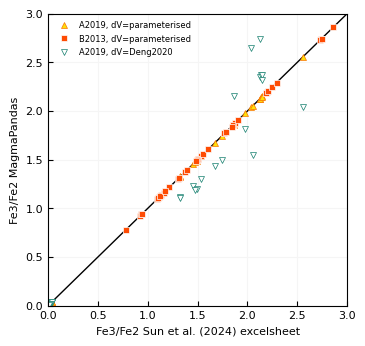

In [46]:
gp.layout(colors=gp.colors.bright)

limits = (0,3)

fig, ax = plt.subplots(1, figsize=(90 * mm, 85 * mm))

ax.plot(limits, limits, "-", c="k")
for ref, df in sun2024_input.groupby("ref"):
    ax.plot(df["_Fe3Fe2_sun2024"], df["Fe3Fe2_magmapandas"], lw=0., label=f"{ref}, dV=parameterised")

df_2 = sun2024_input.query("ref == 'A2019'")
ax.plot(df_2["_Fe3Fe2_sun2024"], df_2["Fe3Fe2_magmapandas_deng"], lw=0., label="A2019, dV=Deng2020")

ax.set_xlim(*limits)
ax.set_ylim(*limits)
ax.legend()

ax.set_xlabel("Fe3/Fe2 Sun et al. (2024) excelsheet")
ax.set_ylabel("Fe3/Fe2 MagmaPandas")

plt.show()

This plot shows results calculated at 1 bar (B2013) and at high pressure (3-23 GPa, A2019). Results with parameterized dV are identical to those from the Sun excel sheet. The values calculated with dV according to Deng et al. (2020) are noticably different. Earlier in this notebook we showed that our code for the Deng model works correctly. Differences from results with parameterized dV are therefore inherent to the Sun model. By default MagmaPandas uses the Deng dV formulation, as this is what the parameterization is originally based on.

### Zhang et al. (2017)

This model uses equation 11 from {cite:t}`Zhang2017`. To validate our code we reproduce Fig. 10. This figure uses a fixed temperater of 1400 degrees C, and fO2 buffered at IW, calculated according to equation S2. Note that the Zhang model doesnt require melt compositions as input

In [47]:
T_K = 1400 + 273.15
P_bar = np.linspace(1, 8e4, 100)

fO2=pd.DataFrame(index=P_bar)
for i in range(-2, 2):
    fO2[i] = IW._fO2_IW_Zhang(logshift=i, T_K=T_K, P_bar=P_bar)

We calculate using dVdT values from Lange and Carmichael (1987, "LC" = 2.92) and Guo et al. (2014, "Guo = 3.69)

In [48]:
Fe3Fe2_zhang_LC = pd.DataFrame(index=P_bar)
Fe3Fe2_zhang_Guo= pd.DataFrame(index=P_bar)

for name, fO2_series in fO2.items():
    Fe3Fe2_zhang_LC[name] = zhang2017.calculate_Fe3Fe2(melt_mol_fractions=None, T_K=T_K, P_bar=P_bar, fO2=fO2_series, parameters="LC")
    Fe3Fe2_zhang_Guo[name] = zhang2017.calculate_Fe3Fe2(melt_mol_fractions=None, T_K=T_K, P_bar=P_bar, fO2=fO2_series, parameters="Guo")

In [49]:
Fe3Fetotal_zhang_LC = Fe3Fe2_zhang_LC / (1+Fe3Fe2_zhang_LC)
Fe3Fetotal_zhang_Guo = Fe3Fe2_zhang_Guo / (1+Fe3Fe2_zhang_Guo)

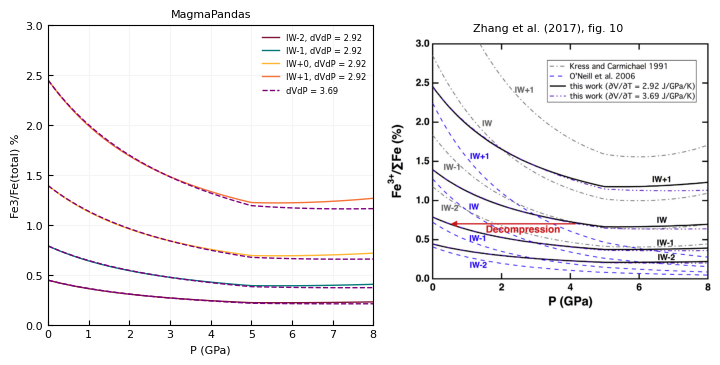

In [50]:
mm = 1/25.4
gp.layout(colors=gp.colors.bella)

fig, axs = plt.subplots(1, 2, figsize=(180*mm, 90*mm))

# for i in Fe3Fetotal_zhang_LC.columns:
for name, Fe3Fetotal_series in Fe3Fetotal_zhang_LC.items():
    axs[0].plot(P_bar/1e4, Fe3Fetotal_series * 100, "-", label=f"IW{name:+}, dVdP = 2.92")
axs[0].plot(P_bar/1e4, Fe3Fetotal_zhang_Guo * 100, "--", c="purple", label=("dVdP = 3.69"))

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles[:5], labels[:5])
axs[0].set_ylim(0, 3)
axs[0].set_xlim(0, 8)

axs[0].set_xlabel("P (GPa)")
axs[0].set_ylabel("Fe3/Fe(total) %")
axs[0].set_title("MagmaPandas")

img = mpimg.imread("./data/Fe3Fe2/Fe3Fe2_zhang2017_fig10.png")
axs[1].imshow(img)
axs[1].axis("off")

axs[1].set_title("Zhang et al. (2017), fig. 10")

plt.show()